In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import random
import warnings

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2

# Suppress warnings
warnings.filterwarnings('ignore')

# Genetic Algorithm Libraries
from deap import base, creator, tools, algorithms

In [7]:
# Fix random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [8]:
class QuietEpochTimeCallback(Callback):
    """
    Custom callback to track epoch training times with minimal logging
    """
    def __init__(self):
        super().__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

class StrokeModelOptimizer:
    def __init__(self, filepath):
        """
        Initialize data, Genetic Algorithm (GA) settings, and constraints.
        """
        # Load and preprocess data
        self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.load_and_preprocess_data(filepath)
        
        # GA Configuration
        self.POPULATION_SIZE = 20
        self.MAX_GENERATIONS = 15
        self.CROSSOVER_PROB = 0.7
        self.MUTATION_PROB = 0.2

        # Gene configuration: ranges for hyperparameters
        self.GENE_CONFIGS = {
            'neurons_layer1': (16, 128),
            'neurons_layer2': (8, 64),
            'dropout_rate1': (0.1, 0.5),
            'dropout_rate2': (0.1, 0.3),
            'learning_rate': (1e-4, 1e-2),
            'l2_reg': (1e-4, 1e-2)
        }

        # Constraints
        self.CONSTRAINTS = {
            'max_training_time': 300,  # seconds
            'max_params': 10000,
            'min_accuracy': 0.75
        }

        self.setup_deap_framework()
        self.history = []

    def load_and_preprocess_data(self, filepath):
        """Load dataset and preprocess."""
        df = pd.read_csv(filepath)
        X = df.drop('stroke', axis=1)
        y = df['stroke']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    def setup_deap_framework(self):
        """Setup DEAP for GA optimization."""
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimize loss, maximize accuracy
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        
        self.toolbox = base.Toolbox()

        # Gene initialization
        for gene, (low, high) in self.GENE_CONFIGS.items():
            self.toolbox.register(f"attr_{gene}", random.uniform, low, high)

        self.toolbox.register("individual", tools.initCycle, creator.Individual,
                             (self.toolbox.attr_neurons_layer1, 
                              self.toolbox.attr_neurons_layer2,
                              self.toolbox.attr_dropout_rate1,
                              self.toolbox.attr_dropout_rate2,
                              self.toolbox.attr_learning_rate,
                              self.toolbox.attr_l2_reg), n=1)
        
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        self.toolbox.register("select", tools.selNSGA2)
        self.toolbox.register("evaluate", self.evaluate_individual)

    def build_ann(self, individual):
        """Build an ANN model based on individual hyperparameters."""
        neurons1, neurons2, drop1, drop2, lr, l2_reg = individual
        model = Sequential([
            Dense(int(neurons1), activation='relu', input_shape=(self.X_train.shape[1],),
                  kernel_regularizer=l2(l2_reg)),
            Dropout(drop1),
            Dense(int(neurons2), activation='relu', kernel_regularizer=l2(l2_reg)),
            Dropout(drop2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def evaluate_individual(self, individual):
        """Evaluate the performance of an ANN defined by individual genes."""
        try:
            model = self.build_ann(individual)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(self.X_train, self.y_train, epochs=50, batch_size=64, validation_split=0.2,
                                verbose=0, callbacks=[early_stopping])
            
            y_pred = (model.predict(self.X_test) > 0.5).astype(int)
            acc = accuracy_score(self.y_test, y_pred)
            loss = model.evaluate(self.X_test, self.y_test, verbose=0)[0]
            return loss, -acc
        except Exception:
            return 1e6, 0

    def visualize_pareto_front(self, population):
        losses = [ind.fitness.values[0] for ind in population]
        accuracies = [-ind.fitness.values[1] for ind in population]
        plt.scatter(losses, accuracies, c='b', label="Pareto Front")
        plt.xlabel("Loss")
        plt.ylabel("Accuracy")
        plt.title("Pareto Front Visualization")
        plt.legend()
        plt.show()

    def run_optimization(self):
        pop = self.toolbox.population(n=self.POPULATION_SIZE)
        algorithms.eaMuPlusLambda(pop, self.toolbox, mu=self.POPULATION_SIZE, lambda_=self.POPULATION_SIZE,
                                  cxpb=self.CROSSOVER_PROB, mutpb=self.MUTATION_PROB,
                                  ngen=self.MAX_GENERATIONS, stats=None, halloffame=None, verbose=True)
        best_ind = tools.selBest(pop, 1)[0]
        print("Best Individual Hyperparameters:", best_ind)
        
        self.visualize_pareto_front(pop)
        model = self.build_ann(best_ind)
        model.fit(self.X_train, self.y_train, epochs=5, batch_size=64, verbose=0)
        y_pred = (model.predict(self.X_test) > 0.5).astype(int)
        
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.show()
        
        fpr, tpr, _ = roc_curve(self.y_test, model.predict(self.X_test))
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()
        
        precision, recall, _ = precision_recall_curve(self.y_test, model.predict(self.X_test))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.show()


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
gen	nevals
0  	20    
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/

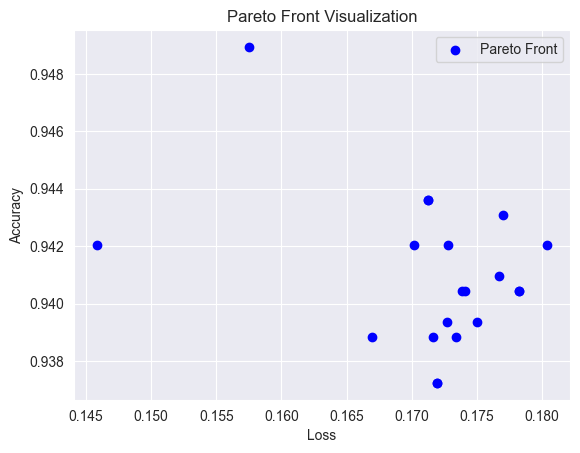

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       940
           1       0.93      0.90      0.91       940

    accuracy                           0.92      1880
   macro avg       0.92      0.92      0.92      1880
weighted avg       0.92      0.92      0.92      1880


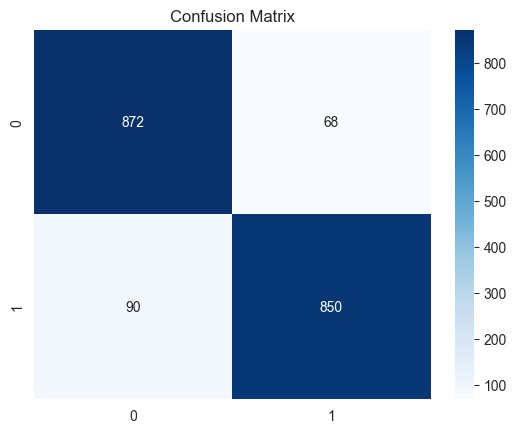

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


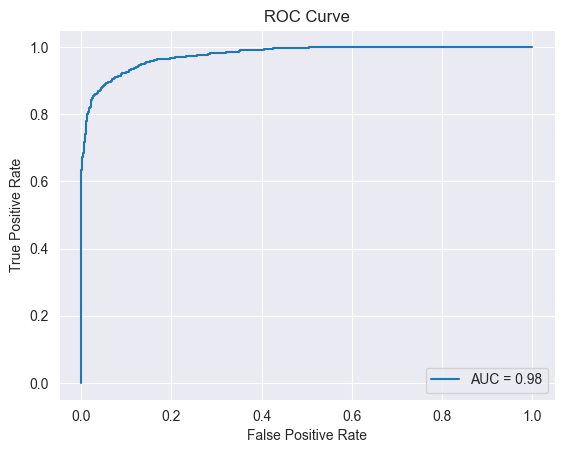

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


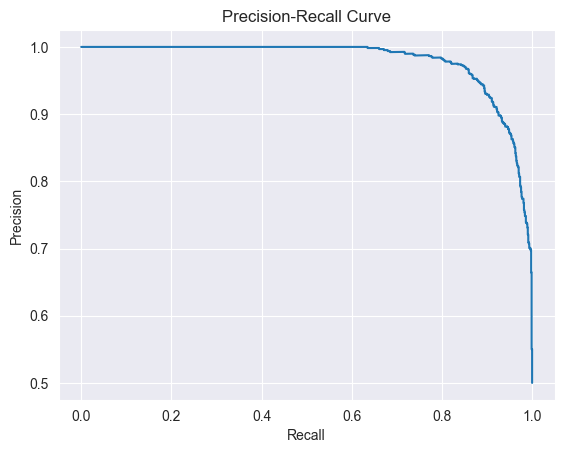

In [9]:
# Run the optimizer
if __name__ == "__main__":
    filepath = r"C:\Users\HP\Documents\GitHub\ci-coursework\cleaned-stroke-prediction-dataset-balanced.csv"  
    optimizer = StrokeModelOptimizer(filepath)
    optimizer.run_optimization()